In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import cv2
import math
from PIL import Image
%matplotlib notebook

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# 一. 数据读取, 数据大致浏览, label分布观察

In [4]:
# 数据读取
TrainData = pd.read_csv('train.csv', index_col=0)
TestData = pd.read_csv('test.csv', index_col=0)
print(TrainData.shape)
print(TestData.shape)

(891, 11)
(418, 10)


In [5]:
TrainData.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
TestData.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


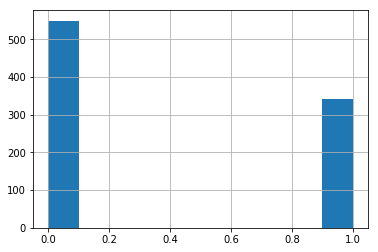

In [7]:
TrainData["Survived"].hist()

In [8]:
# features, labels 拆分
t_copy = TrainData.copy()
train_labels = t_copy.pop("Survived")
train_features = t_copy
test_features = TestData.copy()
train_labels.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [9]:
# train, test 暂时合并 (为了统一处理数据)
train_test_feature = pd.concat((train_features, test_features), axis=0)
print(train_test_feature.shape)
train_test_feature.head()

(1309, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# 二. 剔除无用信息,补全缺失值

In [11]:
# 先剔除无用特征(直观感觉)
try:
    train_test_feature.drop(["Name", "Ticket"], axis=1, inplace=True)
except:
    pass
print(train_test_feature.shape)
train_test_feature.head(2)

(1309, 8)


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,NaN,S
2,1,female,38.0,1,0,71.2833,C85,C


In [12]:
print("【缺失值】:")
print(train_test_feature.isnull().sum())

【缺失值】:
Pclass         0
Sex            0
Age          263
SibSp          0
Parch          0
Fare           1
Cabin       1014
Embarked       2
dtype: int64


count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


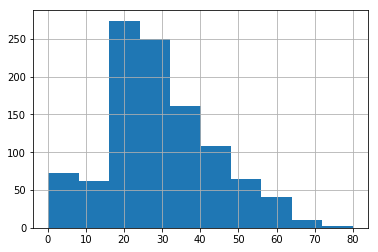

In [13]:
print(train_test_feature["Age"].describe())
train_test_feature["Age"].hist(bins=10)

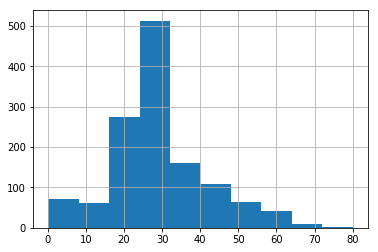

In [14]:
# 填充 Age :
train_test_feature.fillna({"Age":int(train_test_feature["Age"].mean())}, inplace=True)
train_test_feature["Age"].hist(bins=10)

In [15]:
# 观察缺失项 Fare
train_test_feature["Fare"].describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [16]:
np.array(train_test_feature.Fare ==0).sum()  # 发现票价为 0 的乘客有这么多, 那应该也可当做缺失值处理了

# 而且,我发现一个惊天秘密:  这个Fare是和ticket密切相关的,所以ticket实际上不能被作为无关项

17

In [17]:
fare_mt_0 = np.array(train_test_feature.Fare[train_test_feature.Fare >0])
fare_mean = fare_mt_0.sum() // fare_mt_0.shape[0]
fare_mean # 价格大于0的车票的平均价格

33.0

In [18]:
# 填充 Fare
train_test_feature.Fare[train_test_feature.Fare.isnull()] = fare_mean
train_test_feature.Fare[train_test_feature.Fare == 0] = fare_mean
np.array(train_test_feature.Fare == 0).sum()

0

In [19]:
# 填充 Cabin
train_test_feature.pop("Cabin")


PassengerId
1               NaN
2               C85
3               NaN
4              C123
5               NaN
6               NaN
7               E46
8               NaN
9               NaN
10              NaN
11               G6
12             C103
13              NaN
14              NaN
15              NaN
16              NaN
17              NaN
18              NaN
19              NaN
20              NaN
21              NaN
22              D56
23              NaN
24               A6
25              NaN
26              NaN
27              NaN
28      C23 C25 C27
29              NaN
30              NaN
           ...     
1280            NaN
1281            NaN
1282            B24
1283            D28
1284            NaN
1285            NaN
1286            NaN
1287            C31
1288            NaN
1289            B41
1290            NaN
1291            NaN
1292             C7
1293            NaN
1294            NaN
1295            NaN
1296            D40
1297            D38
1298    

In [20]:
train_test_feature.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [21]:
# 填充 Embarked
print(train_test_feature["Embarked"].value_counts())
train_test_feature["Embarked"].fillna("S", inplace=True)
train_test_feature.head(2)

S    914
C    270
Q    123
Name: Embarked, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C


In [22]:
print(train_test_feature.isnull().sum())
# 可见： 缺失值已经填补完成

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [23]:
# 三。 开始分别处理字符型数据（onehot）、数值型数据（是否需要转化）

In [24]:
train_test_feature.describe()

,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,2.294882,29.704102,0.498854,0.385027,33.723825
std,0.837836,12.888034,1.041658,0.865560,51.597683
min,1.000000,0.170000,0.000000,0.000000,3.170800
25%,2.000000,22.000000,0.000000,0.000000,7.925000
50%,3.000000,29.000000,0.000000,0.000000,14.500000
75%,3.000000,35.000000,1.000000,0.000000,32.500000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [25]:
str_features = train_test_feature.dtypes == "object"
print("现数据集中包含 %s 个 '非数值'特征: " % (str_features.sum()), list(train_test_feature.columns[np.array(str_features)]))

现数据集中包含 2 个 '非数值'特征:  ['Sex', 'Embarked']


male      843
female    466
Name: Sex, dtype: int64


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,0,22.0,1,0,7.2500,S
2,1,1,38.0,1,0,71.2833,C


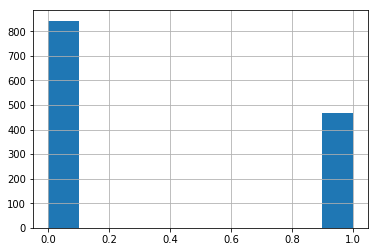

In [26]:
# ① 将 Sex 的str分类标签,改成 0 和 1 (此代码不要执行多遍)
print(train_test_feature["Sex"].value_counts())

train_test_feature["Sex"] = [1 if gender=="female" else 0 for gender in train_test_feature["Sex"]]
train_test_feature["Sex"].hist()
train_test_feature.head(2)

In [27]:
# ② 将Pclass 数值型 转化为 字符型
train_test_feature["Pclass"][train_test_feature["Pclass"] == 1] = "A"
train_test_feature["Pclass"][train_test_feature["Pclass"] == 2] = "B"
train_test_feature["Pclass"][train_test_feature["Pclass"] == 3] = "C"
print(train_test_feature["Pclass"].value_counts())

C    709
A    323
B    277
Name: Pclass, dtype: int64


In [28]:
train_test_feature.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,C,0,22.0,1,0,7.2500,S
2,A,1,38.0,1,0,71.2833,C
3,C,1,26.0,0,0,7.9250,S
4,A,1,35.0,1,0,53.1000,S
5,C,0,35.0,0,0,8.0500,S


In [29]:
# ③ 一次性独热编码
train_test_feature_dummy = pd.get_dummies(train_test_feature)
train_test_feature_dummy.head()

,Sex,Age,SibSp,Parch,Fare,Pclass_A,Pclass_B,Pclass_C,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,0,1,0,0,1
2,1,38.0,1,0,71.2833,1,0,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,1,0,0,1
4,1,35.0,1,0,53.1000,1,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,0,1,0,0,1


In [30]:
# ④ 数值型归一化？ （其实也没啥作用）—— 此处应该不适合，归一后sex变成连续值，age也变成负数
# 归一化应该不太适合分类型的数值 ——→较适合回归问题

In [31]:
# numerical_features = train_test_feature_dummy.dtypes != "uint8"
# numerical_features_index = numerical_features.index[numerical_features]
# numerical_features_index

In [32]:
# import sklearn.preprocessing as sp
# train_test_feature_dummy[numerical_features_index] = sp.scale(train_test_feature_dummy[numerical_features_index])
# train_test_feature_dummy.head()

In [33]:
# 四、 train，test 数据集分离

In [34]:
train_features = train_test_feature_dummy.loc[train_features.index]
test_features = train_test_feature_dummy.loc[test_features.index]
print(train_features.shape)
print(test_features.shape)

(891, 11)
(418, 11)


# 五、 模型选择

# 五（一）、 传统机器学习

In [36]:
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [37]:
# 先随便设一个模型跑一下，主要想检验一下数据清洗是否正常？
# （以后可以都用同个简单的模型来比较，看看哪个数据清理地更干净）
model = RandomForestClassifier(n_estimators=500, random_state=618)
temp = np.random.permutation(pd.concat([train_features, train_labels], axis=1))  # 只是为了打乱顺序后去做个交叉验证，试试数据是否干净
ms.cross_val_score(model, temp[:, :-1], temp[:, -1:], cv=5, scoring="accuracy")  # 测试用的，代码本身并不重要

array([0.77094972, 0.82681564, 0.78651685, 0.79775281, 0.83615819])

In [38]:
# 学习曲线： 看看怎样的train、varify 比例会更好？  （但感觉没啥用，都是运气成分）
_, train_score_matrix, test_score_matrix = ms.learning_curve(model, train_features, train_labels, train_sizes=[0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95], cv=2)
train_score_matrix

array([[1.        , 1.        ],
       [0.9924812 , 1.        ],
       [0.99099099, 1.        ],
       [0.98876404, 0.98501873],
       [0.9903537 , 0.98392283],
       [0.99099099, 0.98498498],
       [0.98876404, 0.98314607],
       [0.985     , 0.9825    ],
       [0.98578199, 0.98341232]])

In [39]:
train_mean_score = train_score_matrix.mean(axis=1) 
test_mean_score =  test_score_matrix.mean(axis=1)
print(train_mean_score, test_mean_score, sep="\n\n")

[1.         0.9962406  0.9954955  0.98689139 0.98713826 0.98798799
 0.98595506 0.98375    0.98459716]

[0.70819771 0.73623973 0.75418199 0.76768277 0.77329823 0.7710586
 0.77441427 0.78563763 0.78227188]


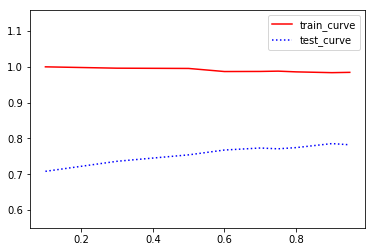

In [40]:
# 学习曲线的真正用途！！！
plt.figure()
plt.axis("equal")
plt.plot([0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95], train_mean_score, "r-", label="train_curve")
plt.plot([0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95], test_mean_score, "b:", label="test_curve")
plt.legend()

In [41]:
# 由上图可看出， 0.9的学习比例可能稍微好一些
# 这样的曲线还算正常的（train_curve缓缓下降， test_curve缓缓上升，最后趋于平衡）
# 这图中的gap还比较大， 好像还可以让模型变得更加复杂一些（稍微过拟合一点应该都不太要紧）

In [42]:
# 训练集和验证集进行分割  (使用上面测出来的0.8作为分割比例)
train_features_split, varify_features_split, train_labels_split, varify_labels_split = ms.train_test_split(train_features, train_labels, test_size=0.1, random_state=618)
print(train_features_split.shape)
print(varify_features_split.shape)

(801, 11)
(90, 11)


In [43]:
# 进行交叉验证，选择最佳模型（此处，只是选择“树”的数量）——（仅是为了案例完整性，意义并不大）
model = RandomForestClassifier(n_estimators=100, random_state=618)
para_list = [{"n_estimators":[100, 200, 300, 400, 500]}]
model = ms.GridSearchCV(model, para_list, cv=3)
model.fit(train_features_split, train_labels_split)
print(model.best_score_, model.best_params_)
model.cv_results_

In [44]:
# 使用网格搜索后的模型（即训练好的模型）  做预测、评分
# model = RandomForestClassifier(n_estimators=100, random_state=618)
# model.fit(train_features_split, train_labels_split)
model.score(varify_features_split, varify_labels_split)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
# 开始对 test_features 做真正的预测：
pred_y = model.predict(test_features)
pred_y.shape

In [ ]:
Y = pd.DataFrame(test_features.index)
Y["Survived"] = pred_y

In [ ]:
Y.head()

In [ ]:
Y.to_csv("gender_submission.csv", index=False)

In [ ]:
# 使用xgboost试试分数：
model = XGBClassifier(max_depth=3, n_estimators=200)
# model = RandomForestClassifier(n_estimators=100, random_state=618)
model.fit(train_features_split, train_labels_split)
model.score(varify_features_split, varify_labels_split)

In [ ]:
_, __, score_matrix = ms.learning_curve(model, train_features, train_labels, train_sizes=[0.6, 0.7, 0.8, 0.9], cv=5)

In [ ]:
score_matrix.mean(1)

In [ ]:
# 训练集和验证集进行分割  (使用上面测出来的0.8作为分割比例)
train_features_split, varify_features_split, train_labels_split, varify_labels_split = ms.train_test_split(train_features, train_labels, test_size=0.1, random_state=618)
print(train_features_split.shape)
print(varify_features_split.shape)

In [ ]:
# # 进行交叉验证，选择最佳模型（此处，只是选择“树”的数量）——（仅是为了案例完整性，意义并不大）
# model = XGBClassifier(max_depth=100)
# para_list = [{"max_depth":[2, 3, 4, 5, 6]}]
# model = ms.GridSearchCV(model, para_list, cv=5)
# model.fit(train_features_split, train_labels_split)
# print(model.best_score_, model.best_params_)
# model.cv_results_

In [ ]:
model.score(varify_features_split, varify_labels_split)

In [ ]:
pred_y = model.predict(test_features)
Y2 = pd.DataFrame(test_features.index)
Y2["Survived"] = pred_y
Y2.to_csv("gender_submission2.csv", index=False)

# 五（二）、 深度神经网络

In [195]:
# 一。 数据处理、准备阶段

#训练集
train_features_split = train_features_split
train_labels_split = train_labels_split


#验证集
varify_features_split = varify_features_split
varify_labels_split = varify_labels_split

#测试集（提交试用）
test_features = test_features

train_data_num = train_features.shape[1]
train_data_num

11

In [56]:
print(train_features_split.shape, varify_features_split.shape, test_features.shape)

(801, 11) (90, 11) (418, 11)


In [57]:
train_labels_split.head(10)

PassengerId
63     0
691    1
872    1
712    0
685    0
632    0
131    0
287    1
653    0
787    1
Name: Survived, dtype: int64

In [196]:
# 二。 超参数、placeholder、w、b的设定
input_features_num = train_data_num
hidden_layer_1_num = 8
hidden_layer_2_num = 8
output_classes= 1


x = tf.placeholder("float", [None,input_features_num], "x")
y = tf.placeholder("float", [None,output_classes], "y")


weights = {
    "w1" : tf.Variable(tf.random_normal([input_features_num, hidden_layer_1_num]), "w1"),
    "w2" : tf.Variable(tf.random_normal([hidden_layer_1_num, hidden_layer_2_num]), "w2"), 
    "w3" : tf.Variable(tf.random_normal([hidden_layer_2_num, output_classes]), "w3"),
}
biases = {
    "b1" : tf.Variable(tf.random_normal([hidden_layer_1_num]), "b1"),
    "b2" : tf.Variable(tf.random_normal([hidden_layer_2_num]), "b2"),
    "b3" : tf.Variable(tf.random_normal([output_classes]), "b3"),
}

In [197]:
# 三、 定义模型（网络结构）
def mlp(x, weights, biases):
    layer_1 = tf.matmul(x, weights["w1"])
    layer_1 = tf.add(layer_1, biases["b1"])
    layer_1 = tf.nn.relu(layer_1, name="relu")
    layer_2 = tf.matmul(layer_1, weights["w2"])
    layer_2 = tf.add(layer_2, biases["b2"])
    layer_2 = tf.nn.relu(layer_2, name="relu2")
    
    output = tf.matmul(layer_2, weights["w3"])
    output = tf.add(output, biases["b3"])
    return output
pred_model = mlp(x, weights, biases)

In [198]:
# 四、 定义（loss + optimizer + metric）
loss_all = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_model, labels=y, name="cross_entropy")
loss = tf.reduce_mean(loss_all)
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
# TD: metric 
prediction = tf.cast(tf.sigmoid(pred_model) > 0.5, tf.float32)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y), tf.float32))

In [277]:
#  五、 执行训练模型
training_epochs = 500
batch_size = 128
loss_lst = []
train_acc_lst = []
varify_acc_lst = []

train_features_copy = train_features_split.copy() #备份数据（为了多次运行调试）
train_labels_copy = train_labels_split.copy() #备份数据（为了多次运行调试）
random_index = np.random.permutation(range(train_features_copy.shape[0])) # 对索引进行乱序！！以此达到同时乱序features和labels数据的目的
train_features_copy = train_features_copy.iloc[random_index]
train_labels_copy = train_labels_copy.iloc[random_index]


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(training_epochs):
        total_batch_num = math.ceil(train_data_num/batch_size) # 有小数，就往上进（跟地板除的不同）
        total_loss = 0
        for n in range(total_batch_num):
            start_index = n * batch_size
            end_index = start_index + batch_size
  
            xs = train_features_copy.iloc[start_index : end_index]
            ys = train_labels_copy.iloc[start_index : end_index][:, None]
            
            #该batch中所有样本的loss值
            l, _ = sess.run([loss, optimizer], feed_dict={x:xs, y:ys})
            total_loss += l
            
            #该batch的训练集的准确率
            train_data_accuracy = sess.run([accuracy], feed_dict={x:xs, y:ys})
            train_acc_lst.append(train_data_accuracy)
            
            #验证集的准确率
            varify_data_accuracy = sess.run([accuracy], feed_dict={x:varify_features_split, y:varify_labels_split[:, None]})
            varify_acc_lst.append(varify_data_accuracy)
            
            
        epoch_loss_mean = total_loss/total_batch_num
        loss_lst.append(epoch_loss_mean)
        if i % 50 == 0:
            print("No.{0} epoch: average loss = {1:.4f}".format(i, epoch_loss_mean))
    
    print("let's start predict!!")
    pred_y = sess.run([prediction], feed_dict={x:test_features})
#     zzzz = sess.run([prediction], feed_dict={x:train_features})
    yyyy = sess.run([prediction], feed_dict={x:varify_features_split})


No.0 epoch: average loss = 170.7223
No.50 epoch: average loss = 6.5975
No.100 epoch: average loss = 0.9679
No.150 epoch: average loss = 0.5615
No.200 epoch: average loss = 0.4933
No.250 epoch: average loss = 0.4621
No.300 epoch: average loss = 0.4548
No.350 epoch: average loss = 0.4488
No.400 epoch: average loss = 0.4434
No.450 epoch: average loss = 0.4382
let's start predict!!


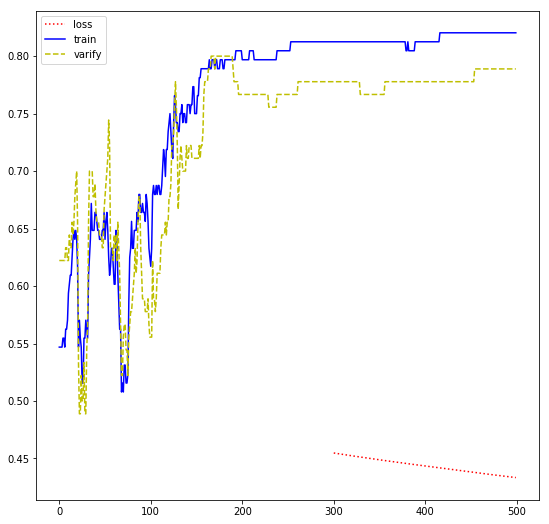

In [278]:
plt.figure(figsize=(9, 9))
plt.plot(np.arange(len(loss_lst))[300:], loss_lst[300:], "r:", label="loss")
plt.plot(np.arange(len(loss_lst)), train_acc_lst, "b-", label="train")
plt.plot(np.arange(len(loss_lst)), varify_acc_lst, "y--", label="varify")
plt.legend()

In [279]:
# 由上图可见，loss在300以后就不怎么变了， varify的accuracy也没有提升了。。。。。（问题到底在哪呢？）
# 以后要勤画图， 画图之后才会对数据更有感觉！！！印象更为深刻
# 而且要同时画出多条曲线，来做比较
# 如果只画单条线会显得比较片面！！（要通盘考虑问题）

In [280]:
print("train_acc:  {0}\n\nvarify_acc:  {1} ".format(max(train_acc_lst),  max(varify_acc_lst)))

train_acc:  [0.8203125]

varify_acc:  [0.8] 


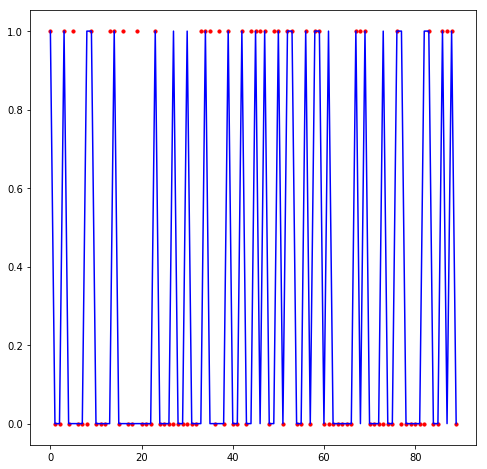

In [289]:
plt.figure(figsize=(8, 8))
plt.scatter(np.arange(90), varify_labels_split, c="r", label="actual", s=10)
plt.plot(np.arange(90), yyyy[0], "b-", label="pred")

In [226]:
Y3 = pd.DataFrame(test_features.index, dtype="int")
Y3["Survived"] = pred_y[0].astype("int")
Y3.to_csv("gender_submission33.csv", index=False)

In [225]:
Y3.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,1
3,895,0
4,896,1


In [ ]:
# 自测：85.5
# 神经网络（优化过多次的模型了）（3层）
# 如果再不行，就只剩两种可能：
# 1、数据清洗没做到位
# 2、数据太少，或者此类数据问题并不适合做“深度学习”

In [232]:
print(train_features.shape, train_labels.shape)

(891, 11) (891,)


In [229]:
train_labels

PassengerId
1      0
2      1
3      1
4      1
5      0
6      0
7      0
8      0
9      1
10     1
11     1
12     1
13     0
14     0
15     0
16     1
17     0
18     1
19     0
20     1
21     0
22     1
23     1
24     1
25     0
26     1
27     0
28     0
29     1
30     0
      ..
862    0
863    1
864    0
865    0
866    1
867    1
868    0
869    0
870    1
871    0
872    1
873    0
874    0
875    1
876    1
877    0
878    0
879    0
880    1
881    1
882    0
883    0
884    0
885    0
886    0
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64